In [1]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

# Load dataset
df = pd.read_csv('f1_2019_to_2023_all_drivers_all_data.csv', low_memory=False)

# Convert time columns to seconds
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

# Convert binary columns to integer type
df['Rainfall'] = df['Rainfall'].astype(int)
df['FreshTyre'] = df['FreshTyre'].astype(int)
df['IsAccurate'] = df['IsAccurate'].astype(int)


# Categorize weather condition based on centroid values of Kmeans clustering
def categorize_weather(row):
    if row['Rainfall'] > 0:
        return 'Rainy'
    elif row['AirTemp'] > 28.43213126:
        return 'high'
    elif row['AirTemp'] > 21.31279265:
        return 'medium'
    elif row['AirTemp'] > 12.84901403:
        return 'low'
    else:
        return 'very_low'

df['Weather_Category'] = df.apply(categorize_weather, axis=1)
df['Original_Weather_Category'] = df['Weather_Category']
df = pd.get_dummies(df, columns=['Weather_Category'])


# Keep the original Driver and Circuit for EDA
df['Original_Driver'] = df['Driver']

# Create Track temperature category based on the result of Kmeans clustering 
df['TrackTemp_Cat'] = pd.cut(df['TrackTemp'], bins=[0, 18.96764999, 27.87457484, 35.04425766, 41.75142602, 50.51006013], labels=['VERY_LOW', 'Low', 'Medium', 'Warm', 'High'])
df['Original_TrackTemp_Cat'] = df['TrackTemp_Cat']
df = pd.get_dummies(df, columns=['TrackTemp_Cat'])


#Feature Engineering with weather condition features
df['TrackConditionIndex'] = (df['AirTemp'] + df['TrackTemp'] + df['Humidity'] + df['Pressure'] +
                             df['WindSpeed'] + df['Rainfall']) / 6





# One-hot encoding
df = pd.get_dummies(df, columns=['Driver', 'Compound', 'Team','TrackStatus'])

# Drop irrelevant columns
columns_to_drop = ['Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
                   'PitOutTime', 'PitInTime', 'LapStartDate', 'Deleted', 'DeletedReason', 'FastF1Generated',
                   'IsPersonalBest', 'Sector3Time','LapStartTime','Sector2Time','Sector1Time','Circuit']
df.drop(columns=columns_to_drop, inplace=True)


# Select numerical values for scaling and imputation
numeric_features = ['Humidity', 'Pressure', 'WindDirection', 'WindSpeed','TrackTemp','AirTemp','TrackConditionIndex','Rainfall','SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']


# Use IterativeImputer for more sophisticated imputation method
iterative_imputer = IterativeImputer(random_state=42)
df[numeric_features] = iterative_imputer.fit_transform(df[numeric_features])


## Separate Rainy / dry days ##
# 1. Separate LapTime as dry or wet(rainy) condition ( since lapTime of rainy day would be recognized as outliers)
# 2. Remove Outliers for dry condition LapTime
# 3. Build Combined LapTime df (Outliers for dry days are deleted)

# Flag for rainy conditions
df['IsRainy'] = df['Rainfall'].apply(lambda x: 1 if x > 0 else 0)

# Separate dataframes for dry and wet conditions
df_dry = df[df['IsRainy'] == 0]
df_wet = df[df['IsRainy'] == 1]

# Remove Outliers for dry days using the IQR method that effective to removes extreme outliers
Q1_dry = df_dry['LapTime'].quantile(0.25)
Q3_dry = df_dry['LapTime'].quantile(0.75)
IQR_dry = Q3_dry - Q1_dry
lower_bound_dry = Q1_dry - 1.5 * IQR_dry
upper_bound_dry = Q3_dry + 1.5 * IQR_dry
df_dry_filtered = df_dry[(df_dry['LapTime'] >= lower_bound_dry) & (df_dry['LapTime'] <= upper_bound_dry)]
df_dry_filtered = df_dry_filtered.copy()
df_wet = df_wet.copy()


## Scaling to the selected numeric features ##
robust_scaler = RobustScaler()

scaler = StandardScaler()

# Applying scaling to the numeric features
df_dry_filtered[numeric_features] = robust_scaler.fit_transform(df_dry_filtered[numeric_features])
df_wet[numeric_features] = robust_scaler.transform(df_wet[numeric_features])  # Use transform, not fit_transform

# Combining the datasets after scaling
df_combined = pd.concat([df_dry_filtered, df_wet], ignore_index=True)
df_combined.info(verbose=True)

/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96556 entries, 0 to 96555
Data columns (total 112 columns):
 #    Column                     Dtype   
---   ------                     -----   
 0    DriverNumber               int64   
 1    LapTime                    float64 
 2    LapNumber                  float64 
 3    Stint                      float64 
 4    SpeedI1                    float64 
 5    SpeedI2                    float64 
 6    SpeedFL                    float64 
 7    SpeedST                    float64 
 8    TyreLife                   float64 
 9    FreshTyre                  int64   
 10   Position                   float64 
 11   IsAccurate                 int64   
 12   AirTemp                    float64 
 13   Humidity                   float64 
 14   Pressure                   float64 
 15   Rainfall                   float64 
 16   TrackTemp                  float64 
 17   WindDirection              float64 
 18   WindSpeed                  float64 
 19   Ye

In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

# Sample data
data = {'Feature1': [10, 20, 15, 2, 3, 110, 15, 20, 25, 3]}
df = pd.DataFrame(data)

# Calculate IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Filtering out outliers based on IQR
filtered_df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Applying RobustScaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(filtered_df)

# Converting scaled data back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=filtered_df.columns)

print("Original Data:")
print(df)
print("\nFiltered Data:")
print(filtered_df)
print("\nScaled Data:")
print(scaled_df)


Original Data:
   Feature1
0        10
1        20
2        15
3         2
4         3
5       110
6        15
7        20
8        25
9         3

Filtered Data:
   Feature1
0        10
1        20
2        15
3         2
4         3
6        15
7        20
8        25
9         3

Scaled Data:
   Feature1
0 -0.294118
1  0.294118
2  0.000000
3 -0.764706
4 -0.705882
5  0.000000
6  0.294118
7  0.588235
8 -0.705882


In [3]:
from sklearn.ensemble import RandomForestRegressor

# Drop Strings columns
df_combined = df_combined.drop(['Original_Driver', 'Original_Weather_Category', 'Original_TrackTemp_Cat'], axis=1)
# Remove rows where 'Position' column contains NaN
df_combined['LapTime'].fillna(method='ffill', inplace=True)

df_combined['Position'].fillna(df_combined['Position'].mean(), inplace=True)

# Define your target and features
X = df_combined.drop('LapTime', axis=1)  # Assuming LapTime is the target variable
y = df_combined['LapTime']

# Fit a random forest to estimate feature importance
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X, y)

# Get feature importances
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")


/var/folders/_5/533f3cq93vq25vl2f3txpkb40000gn/T/ipykernel_2979/338385954.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['LapTime'].fillna(method='ffill', inplace=True)
/var/folders/_5/533f3cq93vq25vl2f3txpkb40000gn/T/ipykernel_2979/338385954.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_combined['LapTime'].fillna(method='ffill', inplace=True)
/var/folders/_5/533f3cq93vq25vl2f3txpkb40000gn/T/ipykernel_2979/3383859

Feature ranking:
1. feature SpeedFL (0.25392292892839663)
2. feature Pressure (0.2031998081362048)
3. feature AirTemp (0.07910972639012577)
4. feature SpeedI2 (0.07745353107924233)
5. feature TrackConditionIndex (0.07416846250812709)
6. feature IsAccurate (0.07349695309820906)
7. feature Humidity (0.053932844436455844)
8. feature Year (0.047107923753811724)
9. feature TrackTemp (0.03163354374954498)
10. feature SpeedI1 (0.022421067143778613)
11. feature SpeedST (0.016110100203467294)
12. feature LapNumber (0.014241144265550497)
13. feature TyreLife (0.013987262335568983)
14. feature WindSpeed (0.0062796972859284214)
15. feature TrackTemp_Cat_High (0.005595339168703858)
16. feature Position (0.005236389683929939)
17. feature WindDirection (0.0036527492195196844)
18. feature Stint (0.0022476154886408883)
19. feature TrackTemp_Cat_Low (0.0017410674355042462)
20. feature IsRainy (0.001483787833050156)
21. feature TrackStatus_4.0 (0.0011591415011241379)
22. feature Rainfall (0.0011176742644

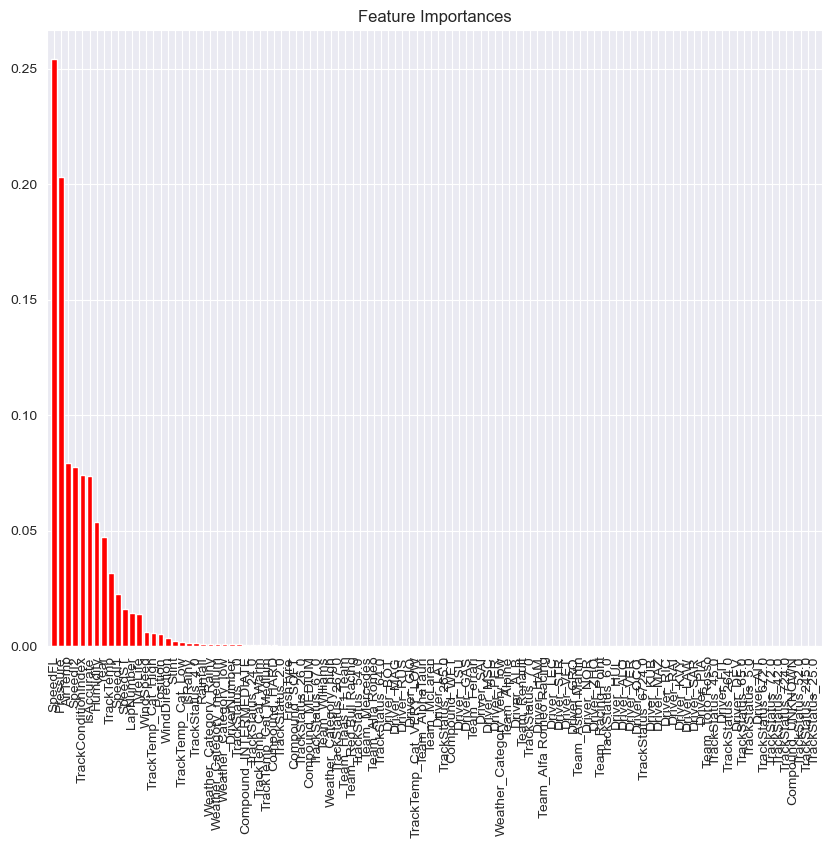

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


In [5]:
from sklearn.feature_selection import RFECV

# Create a RFE object with a RandomForestRegressor and automatically tune the number of features
selector = RFECV(estimator=forest, step=1, cv=5, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title("Feature selection via RFECV")
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (MSE)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

# Mask for selected features
selected_features = X.columns[selector.support_]
print("Selected features:", selected_features)


KeyboardInterrupt: 